# GenAI Empowered Credit Risk Machine Learning Model

## Import Python Modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import ollama
import reportlab
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter 
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

## Talk to GenAI Agent (DeepSeek: deepseek-r1:1.5b)

In [2]:
from GenAI_utilities import GenAI_Analyst,AI_report,evaluate_model
response_text=GenAI_Analyst("What's the future of FinTech?")

## Generate AI_report

In [3]:
# Example usage
AI_report(response_text, "Future of FinTechFinTech_by_GenAI")

## Build Credit Risk PD(Probability of Default) models on LendingClub Data

### Read in Lending Club Data (Accepted Applicants, 2007Q1-2018Q4)

In [4]:
# Load LendingClub data (replace with your dataset)
df = pd.read_csv("~/Desktop/CreditRisk_GenAI/LendingClub_Data/accepted_2007_to_2018q4.csv/accepted_2007_to_2018q4.csv")

# Feature selection: Keep only the relevant features
features = ['fico_range_high', 'loan_amnt', 'annual_inc', 'dti', 'purpose', 'home_ownership', 'emp_length', 'int_rate', 'delinq_2yrs', 'inq_last_6mths', 'tot_coll_amt', 'mths_since_last_delinq']
numeric_features = ['fico_range_high', 'loan_amnt', 'annual_inc', 'dti', 'int_rate', 'tot_coll_amt']
categorical_features = ['purpose', 'home_ownership', 'emp_length']

### Exploratory Data Analysis (EDA): Request Feature Analysis from GenAI Agent

In [5]:
response_text=GenAI_Analyst(f"What are the those features? How could them be related to Probability of Default? {features}")
response_text

"The probability of default (PD) is a measure of the likelihood that a borrower will default on their credit obligations, such as loans or mortgages. The features listed are crucial in predicting PD through various models like credit scoring. Here's how each feature relates to PD:\n\n1. **Fico_range_high**: This refers to the FICO score range, which impacts PD since higher scores correlate with lower risk of default.\n\n2. **Loan_amnt**: Higher loan amounts may lead to more defaults if borrowers face financial constraints, making this a relevant factor in PD prediction.\n\n3. **Annual_inc**: Higher annual incomes generally reduce the likelihood of defaults because borrowers can afford larger payments, affecting PD.\n\n4. **Dti (Days-to-Monthly Payment)**: A higher debt-to-income ratio indicates a greater risk due to potential financial strain, increasing PD.\n\n5. **Purpose**: Different loan types may have different default risks, such as home mortgages typically having lower PD compar

In [6]:
##Ask AI Agent to write a report for feature analysis
AI_report(response_text, "Feature Analysis by GenAI")

In [7]:
response_text=GenAI_Analyst(f"How many categories of loan status? What do they mean? {df['loan_status']}")
response_text

'The data you\'ve provided shows loan statuses labeled from 0 to 2260701, but many of these labels are "Fully Paid" (e.g., 0, 1, 2, 4). This seems redundant because the label "Fully Paid" is used multiple times. It appears that there might be a misalignment in the data indexing or labeling.\n\nHere\'s an analysis based on the provided information:\n\n### Categories of Loan Status:\n1. **Fully Paid**  \n   - These represent loans where the borrower has fully repaid their outstanding debt.\n   - The label "fully paid" is used multiple times, which might indicate that this category is consistent across different instances in the dataset.\n\n2. **Current**  \n   - This indicates that the loan status remains current (unpaid). Some entries in this category are labeled differently (e.g., 2260696 and 2260700), which could be a variation of "current" or an error in labeling.\n\n3. **Charged Off**  \n   - This indicates that the loan has been paid off, but for some reason, it may still have unco

In [8]:
##Ask AI Agent to write a report for Dependent Variable
AI_report(response_text, "Dependent Variable Analysis by GenAI")

### Exploratory Data Analysis (EDA): Box Plot and Histogram

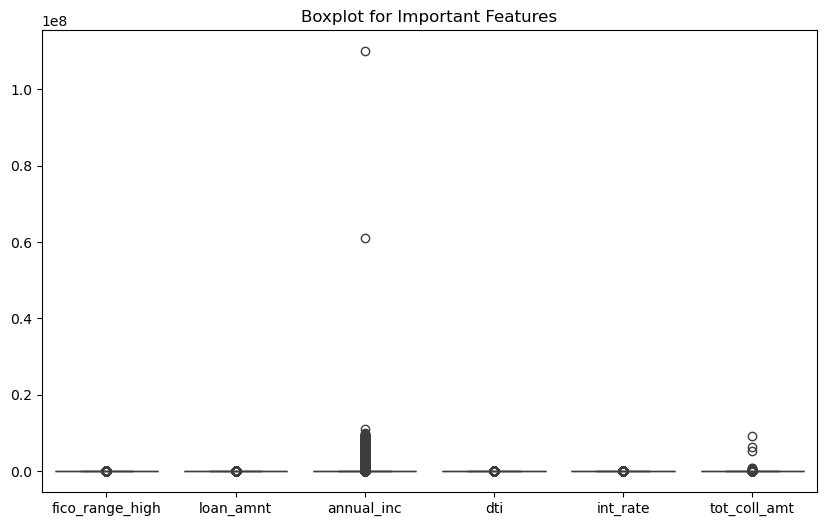

In [9]:
# Create a boxplot for multiple features
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[numeric_features])
plt.title('Boxplot for Important Features')
plt.show()

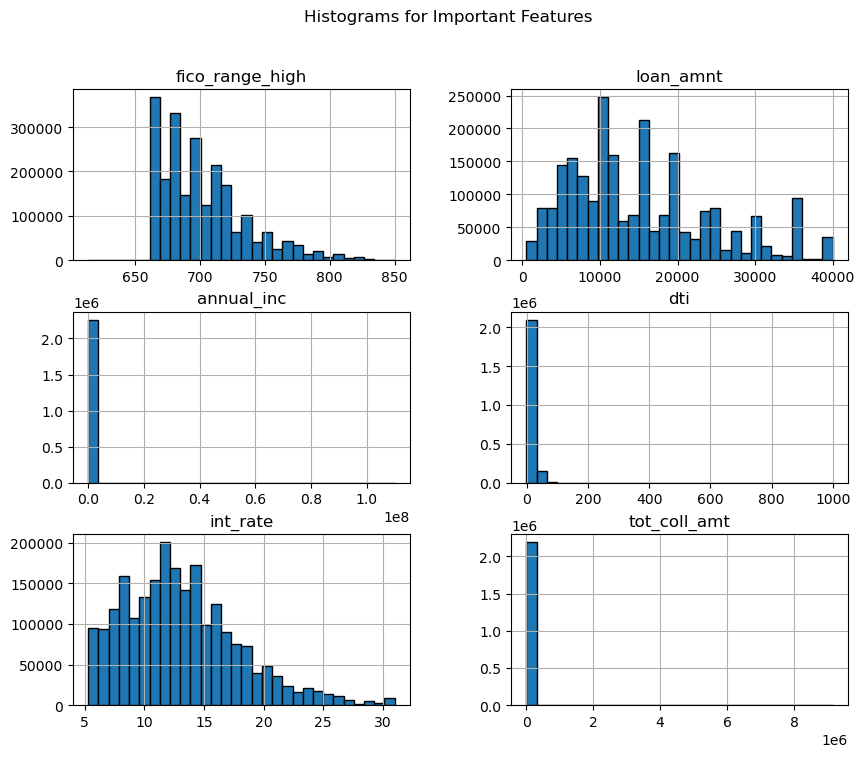

In [10]:
# Plot histograms for multiple continuous features
df[numeric_features].hist(bins=30, figsize=(10, 8), edgecolor='black')
plt.suptitle('Histograms for Important Features')
plt.show()


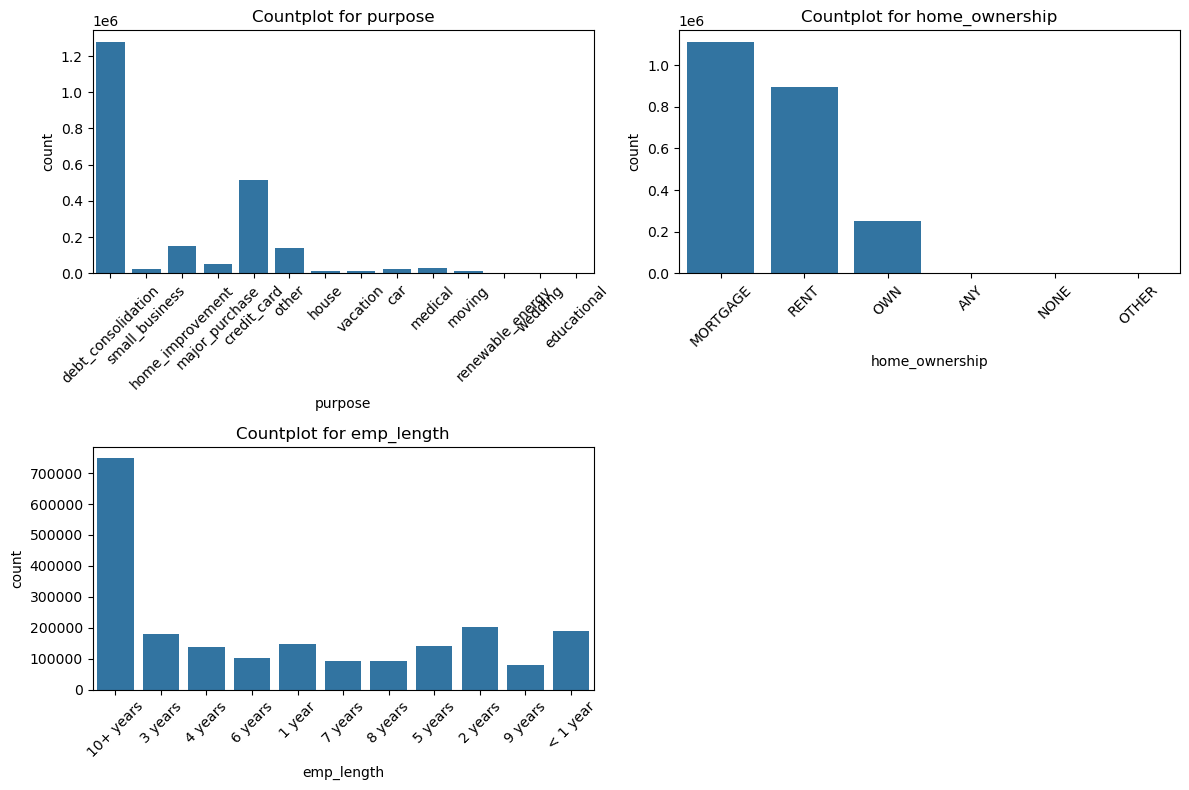

In [11]:
# Bar plots for multiple categorical features
plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_features):
    plt.subplot(2, 2, i + 1)
    sns.countplot(x=col, data=df)
    plt.title(f'Countplot for {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Exploratory Data Analysis (EDA): Correlation Matrix

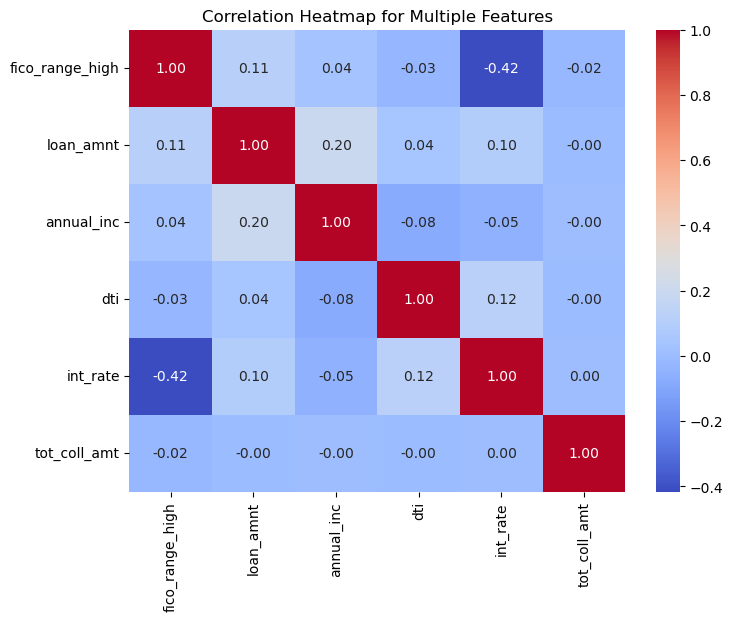

In [12]:
correlation_matrix = df[numeric_features].corr()
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap for Multiple Features')
plt.show()


### Exploratory Data Analysis (EDA): Request Feature Correlationship Analysis from GenAI Agent

In [13]:
Cor_analysis = GenAI_Analyst(f"Please provide insights into the correlationship matrix {correlation_matrix}")
AI_report(Cor_analysis, "Feature Correlationship Analysis by GenAI")

### Feature Engineering: Convert Loan Status into Default

In [14]:
X = df[features]
loan_status_mapping = {
    'Fully Paid': 1,
    'Current': 1,
    'In Grace Period': 1,
    'Late (16-30 days)': 0,
    'Late (31-120 days)': 0,
    'Charged Off': 0,
    'Default': 0
}
# Apply the mapping to the 'Loan_Status' column
df['loan_status_binary'] = df['loan_status'].map(loan_status_mapping)
df.drop('loan_status', axis=1, inplace=True)

y = df['loan_status_binary']
y.value_counts()

loan_status_binary
1.0    1963504
0.0     294415
Name: count, dtype: int64

### Feature Engineering: Cleaning/Imputing Missing Values

In [15]:
# Missing values
for col in X.columns:
    if X[col].isna().sum() != 0:
        missing = X[col].isna().sum()
        portion = (missing / X.shape[0]) * 100
        print(f"'{col}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'fico_range_high': number of missing values '33' ==> '0.001%'
'loan_amnt': number of missing values '33' ==> '0.001%'
'annual_inc': number of missing values '37' ==> '0.002%'
'dti': number of missing values '1744' ==> '0.077%'
'purpose': number of missing values '33' ==> '0.001%'
'home_ownership': number of missing values '33' ==> '0.001%'
'emp_length': number of missing values '146940' ==> '6.500%'
'int_rate': number of missing values '33' ==> '0.001%'
'delinq_2yrs': number of missing values '62' ==> '0.003%'
'inq_last_6mths': number of missing values '63' ==> '0.003%'
'tot_coll_amt': number of missing values '70309' ==> '3.110%'
'mths_since_last_delinq': number of missing values '1158535' ==> '51.247%'


In [16]:
# Fill missing numerical data with median (less sensitive to outliers)
X[numeric_features] = X[numeric_features].fillna(X[numeric_features].median())
# Fill missing categorical data with mode (most frequent value)
for cat in categorical_features:
    X[cat] = X[cat].fillna(X[cat].mode()[0])
y=y.fillna(y.mode()[0])

In [17]:
# Re-Check Missing values
for col in X.columns:
    if X[col].isna().sum() != 0:
        missing = X[col].isna().sum()
        portion = (missing / X.shape[0]) * 100
        print(f"'{col}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'delinq_2yrs': number of missing values '62' ==> '0.003%'
'inq_last_6mths': number of missing values '63' ==> '0.003%'
'mths_since_last_delinq': number of missing values '1158535' ==> '51.247%'


In [18]:
# Handle each column individually
X['mths_since_last_delinq'] = X['mths_since_last_delinq'].fillna(X['mths_since_last_delinq'].mean())
X['delinq_2yrs'] = X['delinq_2yrs'].fillna(X['delinq_2yrs'].mean())
X['inq_last_6mths'] = X['inq_last_6mths'].fillna(X['inq_last_6mths'].mean())


### Train Machine Learning (ML) PD Models

In [19]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.25,random_state=42)

In [20]:
X_train.dtypes

fico_range_high           float64
loan_amnt                 float64
annual_inc                float64
dti                       float64
purpose                    object
home_ownership             object
emp_length                 object
int_rate                  float64
delinq_2yrs               float64
inq_last_6mths            float64
tot_coll_amt              float64
mths_since_last_delinq    float64
dtype: object

In [21]:
# Preprocessing for numeric data (scaling)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Train-test split FIRST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Preprocess data PROPERLY
X_train = preprocessor.fit_transform(X_train)  # Learn scaling/encoding from train
X_test = preprocessor.transform(X_test)     

#### Load Modules for ML Models

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, recall_score, fbeta_score, roc_auc_score,
    classification_report, RocCurveDisplay)
from GenAI_utilities import evaluate_model

#### Logistic Regression Model for PDs

Results for Logistic Regression:
Confusion Matrix:
[[   233  58674]
 [   452 392782]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.34      0.00      0.01     58907
         1.0       0.87      1.00      0.93    393234

    accuracy                           0.87    452141
   macro avg       0.61      0.50      0.47    452141
weighted avg       0.80      0.87      0.81    452141

Accuracy: 0.8692
Recall: 0.9989
F2 Score: 0.9701
AUC: 0.6830




<Figure size 400x400 with 0 Axes>

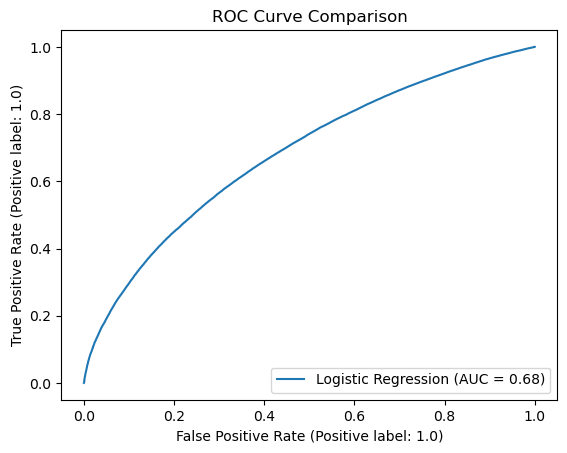

In [23]:
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
results = []
results.append(evaluate_model(lr_model, X_test, y_test, "Logistic Regression"))
plt.figure(figsize=(4, 4))
RocCurveDisplay.from_estimator(lr_model, X_test, y_test, name="Logistic Regression")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()


#### Request GenAI to analyze the Logistic Regression Model

In [24]:
lr=GenAI_Analyst(f"Please interpretet the Logistic Regression Model we have built!{lr_model}")
##Ask AI Agent to write a report for response variable
AI_report(lr, "Logistic Regression Model Analysis by GenAI")

#### Gradient Boosting Model for PDs

Results for Gradient Boosting:
Confusion Matrix:
[[     1  58906]
 [     7 393227]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.12      0.00      0.00     58907
         1.0       0.87      1.00      0.93    393234

    accuracy                           0.87    452141
   macro avg       0.50      0.50      0.47    452141
weighted avg       0.77      0.87      0.81    452141

Accuracy: 0.8697
Recall: 1.0000
F2 Score: 0.9709
AUC: 0.7033




<Figure size 400x400 with 0 Axes>

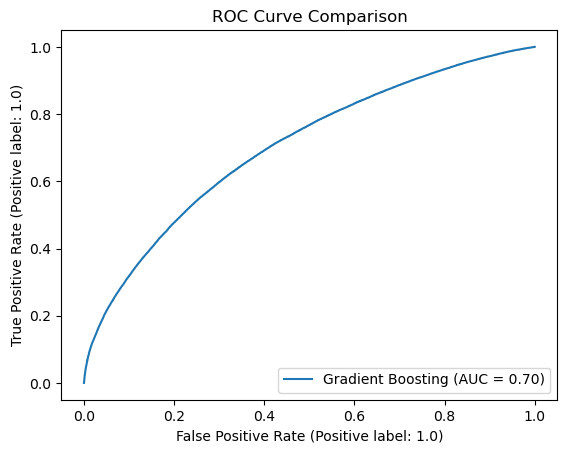

In [25]:
# Gradient Boosting Model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
results.append(evaluate_model(gb_model, X_test, y_test, "Gradient Boosting"))
# Plot ROC Curves 
plt.figure(figsize=(4, 4))
RocCurveDisplay.from_estimator(gb_model, X_test, y_test, name="Gradient Boosting")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()

In [26]:
#### Request GenAI to analyze the Gradient Boosting Model

In [27]:
gb=GenAI_Analyst(f"Please interpretet the Logistic Regression Model we have built!{gb_model}")
##Ask AI Agent to write a report for response variable
AI_report(gb, "Gradient Boosting Model Analysis by GenAI")

#### Neural Network Model for PDs

Results for Neural Network:
Confusion Matrix:
[[    14  58893]
 [    28 393206]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.33      0.00      0.00     58907
         1.0       0.87      1.00      0.93    393234

    accuracy                           0.87    452141
   macro avg       0.60      0.50      0.47    452141
weighted avg       0.80      0.87      0.81    452141

Accuracy: 0.8697
Recall: 0.9999
F2 Score: 0.9709
AUC: 0.6949




<Figure size 400x400 with 0 Axes>

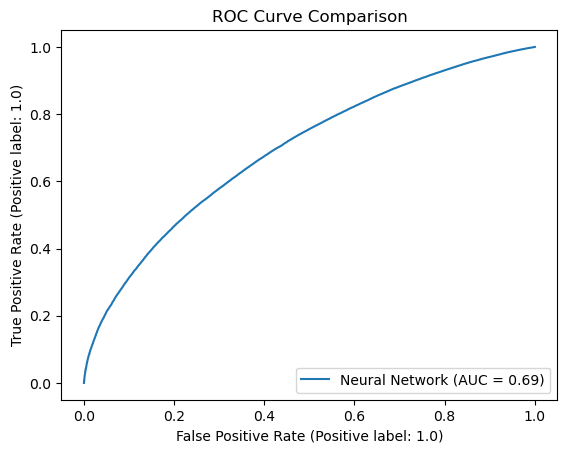

In [28]:
nn_model = MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=300, random_state=42, solver='adam')
nn_model.fit(X_train, y_train)
results.append(evaluate_model(nn_model, X_test, y_test, "Neural Network"))
# Plot ROC Curve
plt.figure(figsize=(4, 4))
RocCurveDisplay.from_estimator(nn_model, X_test, y_test, name="Neural Network")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()

In [29]:
#### Request GenAI to analyze the Neural Network Model

In [30]:
nn=GenAI_Analyst(f"Please interpretet the Logistic Regression Model we have built!{nn_model}")
##Ask AI Agent to write a report for response variable
AI_report(nn, "Gradient Boosting Model Analysis by GenAI")

### Summarize the Results for Candidate Models

In [31]:
results_df = pd.DataFrame(results)
print("Summary of Results:")
print(results_df)

Summary of Results:
                 Model  Accuracy    Recall        F2       AUC
0  Logistic Regression  0.869231  0.998851  0.970123  0.683009
1    Gradient Boosting  0.869702  0.999982  0.970898  0.703330
2       Neural Network  0.869684  0.999929  0.970862  0.694878


#### GenAI Agent to Interpret ML Models

In [32]:
lr=GenAI_Analyst(f"Please provide insights compare the candidate models{results_df}")
##Ask AI Agent to write a report for response variable
AI_report(lr, "Credit Risk PD Models Insights by GenAI")